<center><h1>Multinomial Classification of Interest Levels for RentHop.com Listings</h1></center>
<center><h3>Clarence Ngoh, Serene Gao</h3></center>
<br>
<center>April 15, 2017</center>
<hr>
<center><h3>Abstract</h3></center>
<p>
<a href="https://www.renthop.com"><strong>RentHop</strong></a> is a web and mobile-based search engine that allows users to search for rental housing in many major cities in the US. Created in February 2009 to solve the problem of hunting for a suitable apartment, RentHop has continually refined its sorting algorithm to allow users to search smarter - using data to sort rental listings by quality.
</p>
<p>
For our project, we make use of RentHop’s listing data hosted on <a href="https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries">Kaggle.com</a> to predict the interest level for new listings, given publicly available attributes of current listings. We are motivated by the potential to uncover business value as the results can help agents better understand renters’ needs and preferences. 
</p>
<br>
<br>

<center><h3>Exploratory Data Analysis</h3></center>

In [1]:
# importing required dependencies
import pandas as pd
import numpy as np

# visualisation 
from IPython.display import display
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# import sklearn dependencies
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# others
import geocoder as geo

/Users/clarencenpy/miniconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [46]:
# loading dataset
train = pd.read_json('train.json')

### Basic 

Let's first look at the some basic attributes of our dataset.

In [3]:
# size of the dataset
train.shape

(49352, 15)

In [4]:
# show the available features
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')

In [5]:
# get a sense of the format of the data
train.head().T

,10,10000,100004,100007,100013
bathrooms,1.5,1,1,1,1
bedrooms,3,2,1,1,4
building_id,53a5b119ba8f7b61d4e010512e0dfc85,c5c8a357cba207596b04d1afd1e4f130,c3ba40552e2120b0acfc3cb5730bb2aa,28d9ad350afeaab8027513a3e52ac8d5,0
created,2016-06-24 07:54:24,2016-06-12 12:19:27,2016-04-17 03:26:41,2016-04-18 02:22:02,2016-04-28 01:32:41
description,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,,"Top Top West Village location, beautiful Pre-w...",Building Amenities - Garage - Garden - fitness...,Beautifully renovated 3 bedroom flex 4 bedroom...
display_address,Metropolitan Avenue,Columbus Avenue,W 13 Street,East 49th Street,West 143rd Street
features,[],"[Doorman, Elevator, Fitness Center, Cats Allow...","[Laundry In Building, Dishwasher, Hardwood Flo...","[Hardwood Floors, No Fee]",[Pre-War]
interest_level,medium,low,high,low,low
latitude,40.7145,40.7947,40.7388,40.7539,40.8241
listing_id,7211212,7150865,6887163,6888711,6934781


In [6]:
# Get statistical summary of the numerical features
train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


### Target Variable Analysis

Here, we focus on the target variable, which is the interest_level that we want to predict. 

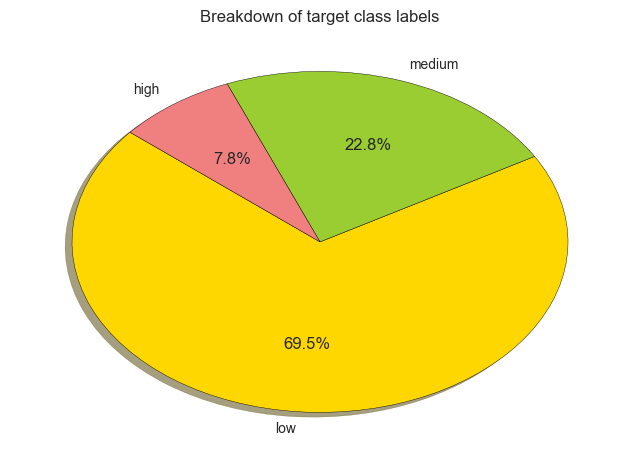

In [7]:
# lets look at the distribution of the different target classes within the training dataset
class_sizes = train['interest_level'].value_counts().values
labels = ['low', 'medium', 'high']
colors = ['gold', 'yellowgreen', 'lightcoral']
plt.pie(class_sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Breakdown of target class labels")
plt.show()

We can observe class imbalance within the training set, where the 3 interest_levels are not represented equally. This could mean that our predicted results are only valid with the underlying distribution, affecting the ability of our model to generalised to other datasets. 

### Extreme Value Analysis

In this section, we want to look at the distribution of numerical variables, paying special attention to the presence of any outliers that we can remove before training the model. Doing this step first will help us reduce noise.

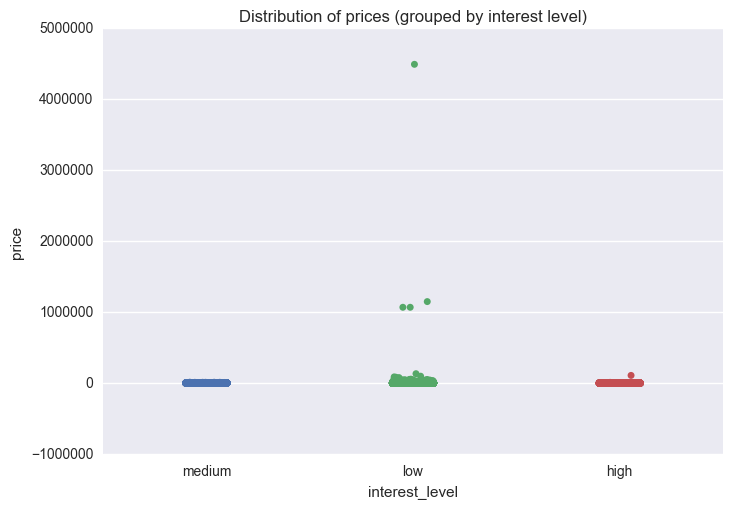

In [8]:
sns.stripplot(train['interest_level'], train['price'], jitter=True)
plt.title('Distribution of prices (grouped by interest level)')
plt.show()

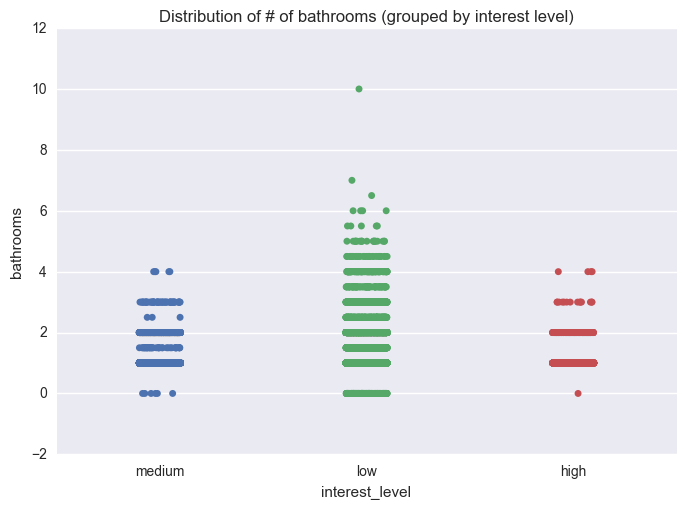

In [9]:
sns.stripplot(train['interest_level'], train['bathrooms'], jitter=True)
plt.title('Distribution of # of bathrooms (grouped by interest level)')
plt.show()

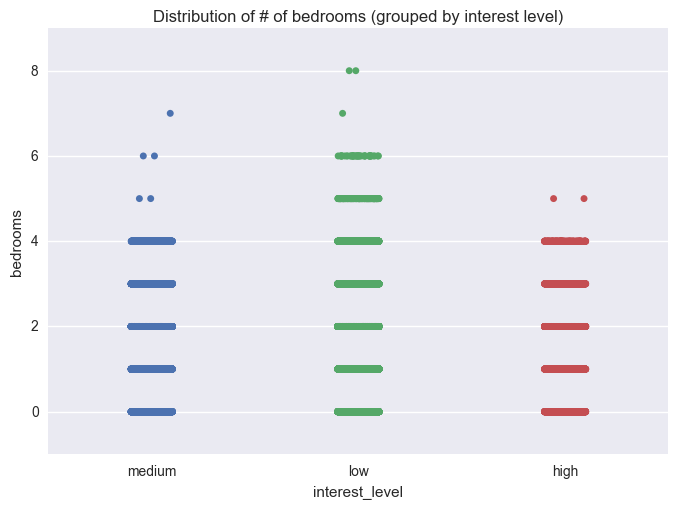

In [10]:
sns.stripplot(train['interest_level'], train['bedrooms'], jitter=True)
plt.title('Distribution of # of bedrooms (grouped by interest level)')
plt.show()

From the above scatter plots, we already observe outliers that can be removed! For example, there is a single listing with 10 bathrooms, and another with a price tag of almost $5m. 

In [11]:
# removing the outliers from the data
train = train[train['price'] < np.percentile(train.price.values, 99)] # remove price outliers
train = train[train['bathrooms'] < 10] # remove bathroom outlier

<center><h3>Baseline Model</h3></center>

Let's build a baseline model with the minimal amount of preparation we have done with the dataset. This will allow us to evaluate further actions against. We will only consider the numerical features for now.

In [12]:
# lets first define a helper function that will help us evaluate our model against a few metrics
def evaluate(clf, X_test, Y_test, clf_name):
    print("===== {} =====".format(clf_name))
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    
    print("Accuracy: {}".format(accuracy_score(Y_test, predicted)))
    print("Log Loss: {}".format(log_loss(Y_test, predicted_prob)))
    labels = ['low', 'medium', 'high']

    print("Confusion Matrix:")
    display(pd.DataFrame(data=confusion_matrix(Y_test, predicted, labels=['low', 'medium', 'high']), index=labels, columns=labels))
    
    print("Report:")
    print(classification_report(Y_test, predicted))

In [13]:
# extract X and Y
y_train = train['interest_level'].values
x_train = train[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price']] # use only numerical features

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "Baseline Model (numerical features only)")

===== Baseline Model (numerical features only) =====
Accuracy: 0.6908904810644831
Log Loss: 2.905326075910006
Confusion Matrix:


,low,medium,high
low,5804,780,166
medium,1321,710,237
high,284,232,236


Report:
             precision    recall  f1-score   support

       high       0.37      0.31      0.34       752
        low       0.78      0.86      0.82      6750
     medium       0.41      0.31      0.36      2268

avg / total       0.67      0.69      0.68      9770



<center><h3>Exploratory Data Analysis (continued)</h3></center>

Now that we have a baseline model, let's get back to EDA to figure out what other features could be used to improve the baseline model.

### Feature Discretization

There is a whole lot of data that we are ignoring when we only look at numerical features. One way to get more utility out of the data is to discretize some non-numerical features into classes. 

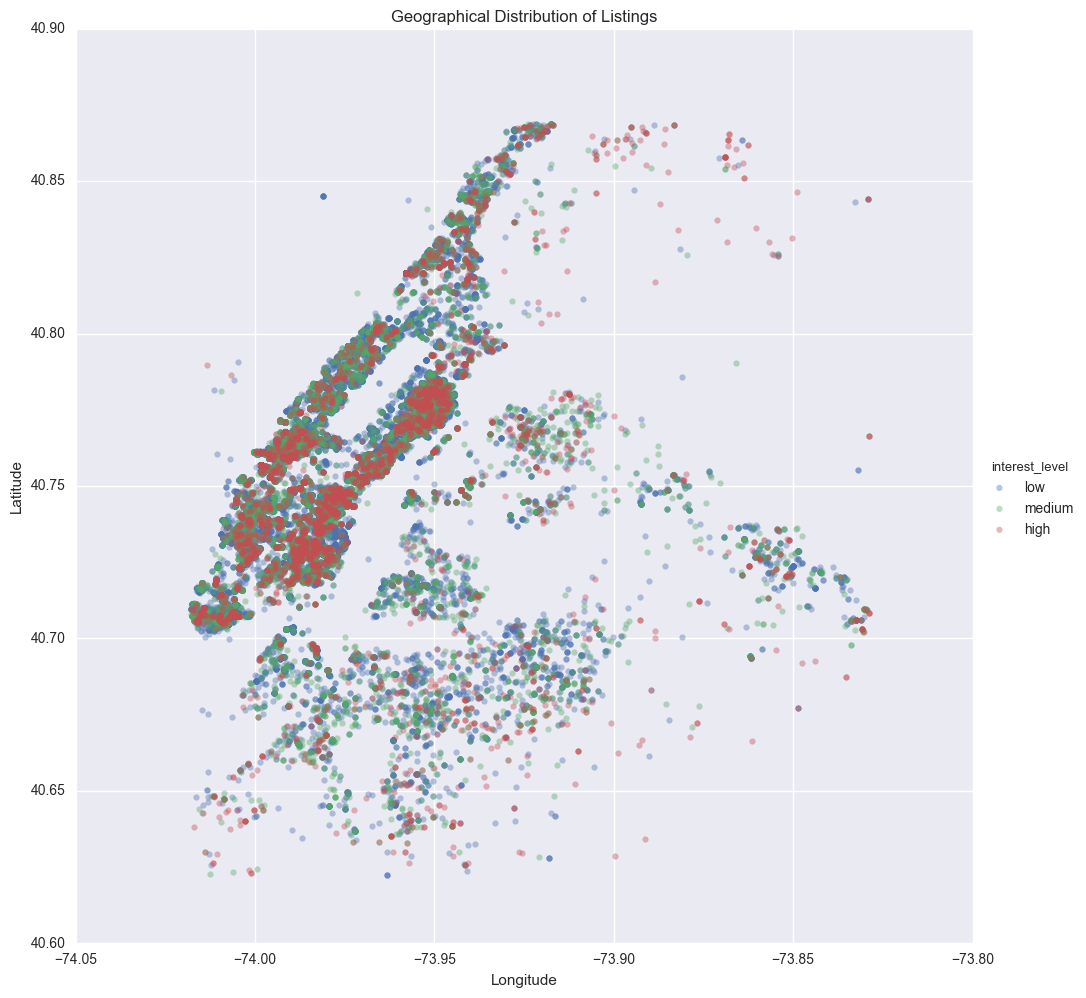

In [14]:
# first, we look at the location information (lat and lng)
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=10, scatter_kws={'alpha':0.4},
           data=train[(train.longitude>train.longitude.quantile(0.005)) # remove outliers so we can get a better view
                           &(train.longitude<train.longitude.quantile(0.995))
                           &(train.latitude>train.latitude.quantile(0.005))                           
                           &(train.latitude<train.latitude.quantile(0.995))])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Geographical Distribution of Listings")
plt.show()

There seems like there could be some clustering of high interest listings, which means that location could be a useful predictor. Instead of using the raw latitude/longitude values, we hypothesize that we can reduce noise and increase accuracy by looking up the exact neighborhood instead.

In [197]:
# add a new neighborhood column

def get_neighborhood(latlng):
    return
    res = geo.google(latlng.tolist(), method='reverse')
    return res.neighborhood    

# train.assign(neighborhood=[get_neighborhood(x) for x in train[['latitude', 'longitude']].values])

We can also make use of `LabelBinarizer` to start making use of the categorical variables in our dataset to train the model. We will do this pre-processing step on building_id and manager_id. 

In [47]:
from sklearn import preprocessing
lb_managerid = preprocessing.LabelBinarizer()
lb_managerid.fit(train['manager_id'])
lb_buildingid = preprocessing.LabelBinarizer()
lb_buildingid.fit(train['building_id'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [48]:
managerids = pd.DataFrame(lb_managerid.transform(train['manager_id']))
buildingids = pd.DataFrame(lb_buildingid.transform(train['building_id']))

In [51]:
train1 = train.reset_index() # so there are no problems concatenating
train1 = train1.drop('index', axis=1)
train1 = pd.concat([train1, managerids, buildingids], axis=1)
train1 = train1.drop(['building_id', 'manager_id'], axis=1)

While we are not using any form of image recognition in our model just yet, our intuition is that the number of photos that a listing has should also affect its interest level. Let's make that into a feature too.

In [59]:
train1 = train1.assign(photo_count=[len(photos) for photos in train1['photos'].values])

Let's see how our model improves now with after all these steps

In [60]:
# extract X and Y
y_train = train1['interest_level'].values
x_train = train1.drop(['interest_level', 'created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "After applying discretization to categorical variables")

===== After applying discretization to categorical variables =====
Accuracy: 0.7252557998176477
Log Loss: 2.2949721237521468
Confusion Matrix:


,low,medium,high
low,6261,492,79
medium,1410,674,172
high,293,266,224


Report:
             precision    recall  f1-score   support

       high       0.47      0.29      0.36       783
        low       0.79      0.92      0.85      6832
     medium       0.47      0.30      0.37      2256

avg / total       0.69      0.73      0.70      9871



### Textual Features

This dataset is interesting because in addition to numerical features, we also have 2 fields with textual data. We shall visualize them to see if we can find a meaningful way to use them.

In [11]:
train['features'].values

array([[],
       ['Doorman', 'Elevator', 'Fitness Center', 'Cats Allowed', 'Dogs Allowed'],
       ['Laundry In Building', 'Dishwasher', 'Hardwood Floors', 'Pets Allowed Case by Case'],
       ...,
       ['Doorman', 'Elevator', 'Pre-War', 'Dogs Allowed', 'Cats Allowed'],
       ['Doorman', 'Elevator', 'Pre-War', 'Dogs Allowed', 'Cats Allowed'],
       ['Hardwood Floors']], dtype=object)

In [12]:
# accumulate word tokens from text fields
feature_arr = []
description_arr = []
for w in train['features'].values:
    feature_arr.extend(w)
for w in train['description'].values:
    description_arr.extend(w.split())

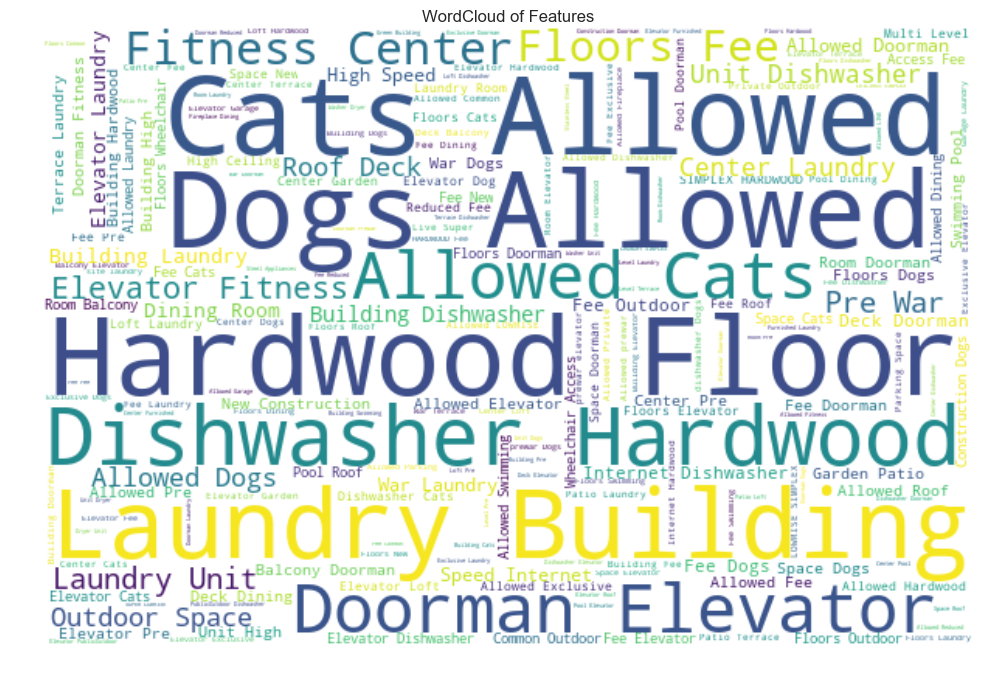

In [148]:
wordcloud = WordCloud(background_color='white', width=600, height=400).generate(' '.join(feature_arr))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Features')
plt.show()

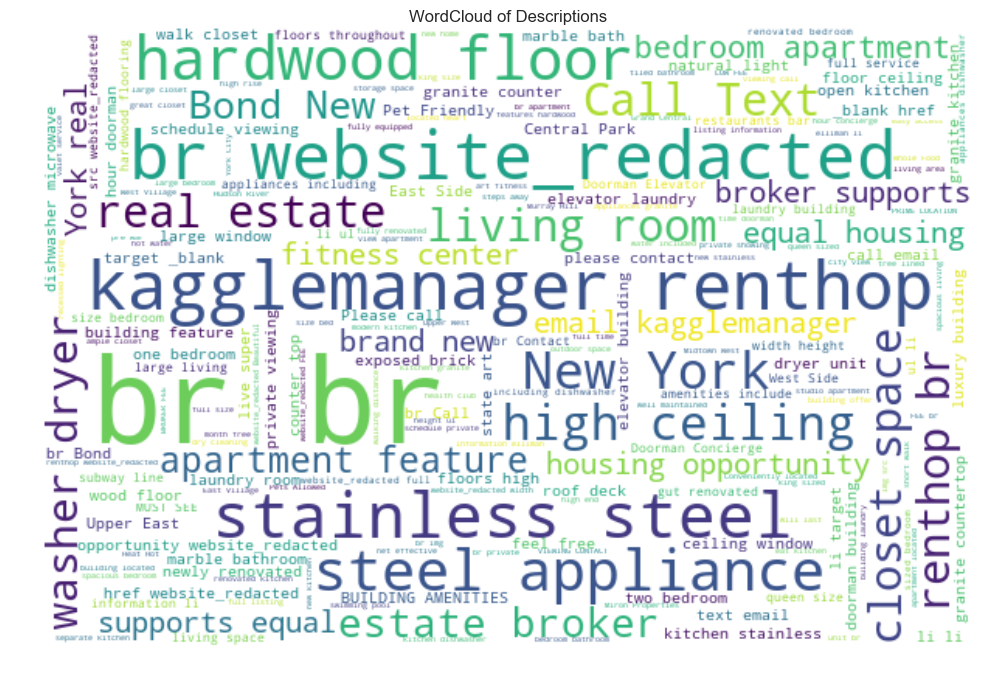

In [149]:
wordcloud = WordCloud(background_color='white', width=600, height=400).generate(' '.join(description_arr))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Descriptions')
plt.show()

Other ideas of things to look at: 

- Number of listings in the same building
- Number of listings managed by the same manager
- Date? Not sure if this is a useful feature to look at
- Number of photos?
- Number of features?
- Clustering of coordinates into grids (can round off latlng values)
- API to lookup the neighborhood